# Conversion Challenge
Data from a newsletter to better understand the behaviour of users visiting the website and predict if a given user will subscribe.
This started as a challenge during the Jedha Fullstack course to produce the best model, within a short amount of time.

## Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"

## Read file & explore dataset

In [2]:
data = pd.read_csv('data/conversion_data_train.csv')
print(data.shape)

(284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [4]:
data.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [5]:
# incoherent ages (123) : dropping age values 4 stds above mean
data = data.loc[data['age'] < (data['age'].mean())+(data['age'].std()*4)]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284515 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284515 non-null  object
 1   age                  284515 non-null  int64 
 2   new_user             284515 non-null  int64 
 3   source               284515 non-null  object
 4   total_pages_visited  284515 non-null  int64 
 5   converted            284515 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 15.2+ MB


In [7]:
print(data['source'].value_counts())
print(data['country'].value_counts())

Seo       139444
Ads        80008
Direct     65063
Name: source, dtype: int64
US         160086
China       69104
UK          43635
Germany     11690
Name: country, dtype: int64


In [8]:
# Conversion rate 
print(data['converted'].mean())

0.032258404653533204


Very low conversion rate ; the data is heavily imbalanced.

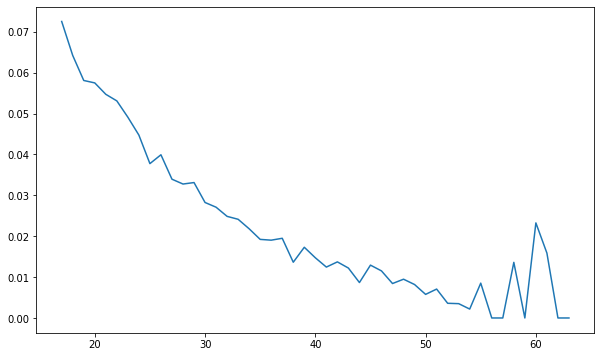

In [9]:
data_ages = data.groupby('age')[['converted']].mean()
plt.figure(figsize=(10,6))
plt.plot(data_ages.index,data_ages['converted'])
plt.show()

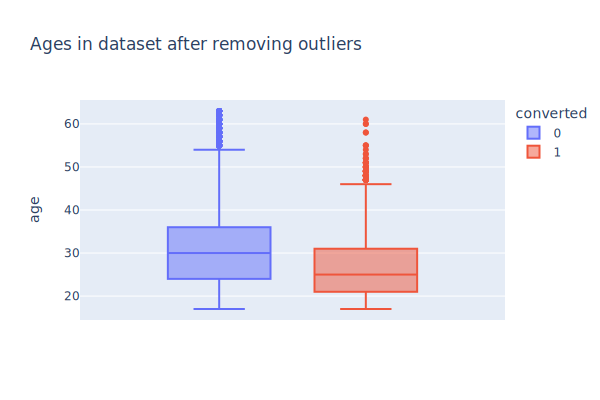

In [10]:
px.box(data, y = 'age', color = 'converted', title = 'Ages in dataset after removing outliers',width=600, height=400)

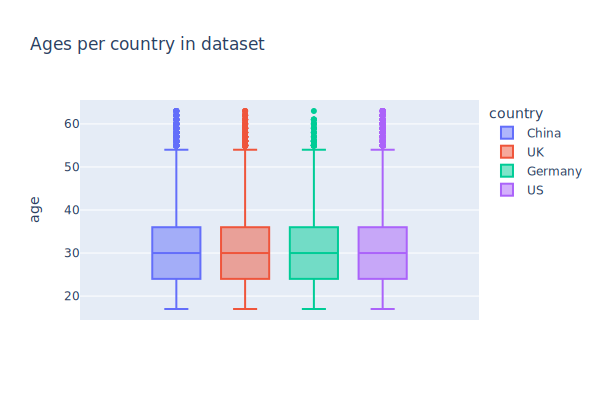

In [11]:
px.box(data, y = 'age', color = 'country', title = 'Ages per country in dataset',width=600, height=400)

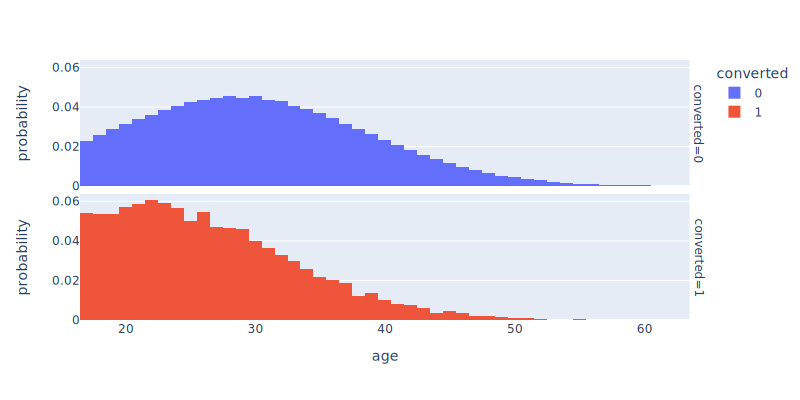

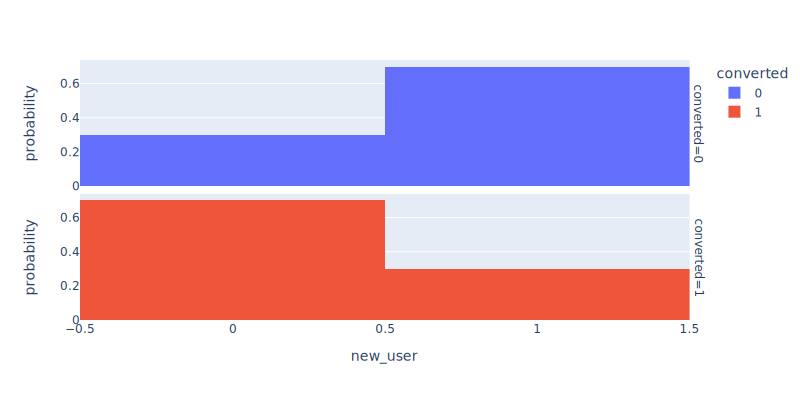

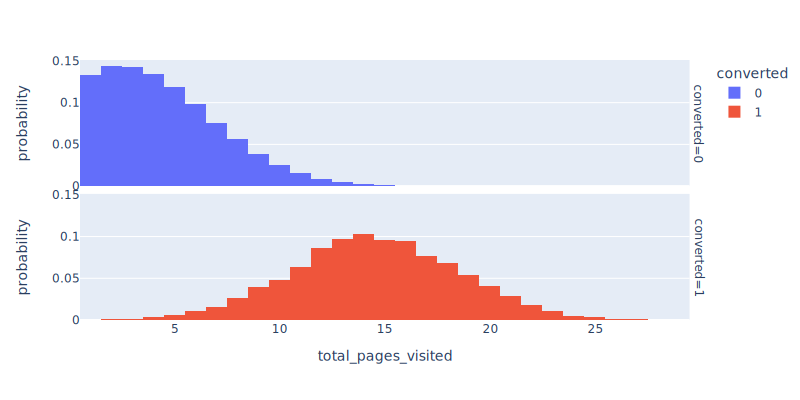

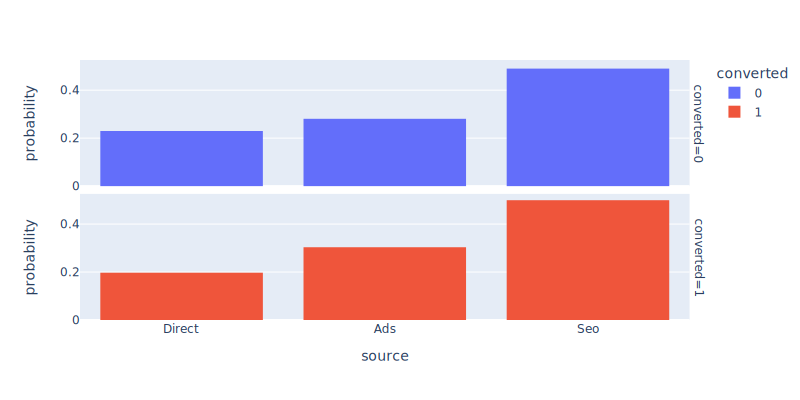

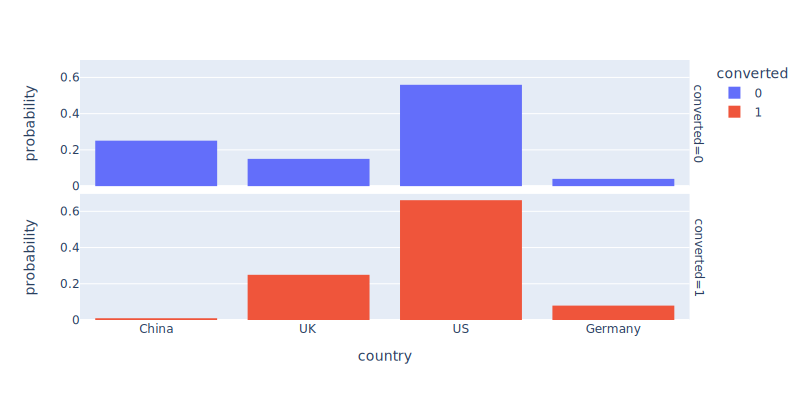

In [12]:
plot_features = ['age', 'new_user','total_pages_visited','source','country']
for f in plot_features:
    fig = px.histogram(data, f, color = 'converted', facet_row = 'converted', histnorm = 'probability',width=800, height=400)
    fig.show()

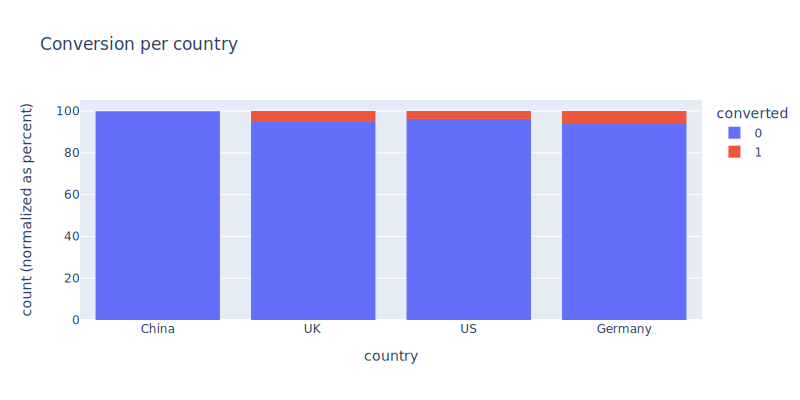

In [13]:
fig = px.histogram(data, x = 'country', color = 'converted', title = 'Conversion per country',barnorm = 'percent', width=800, height=400)
fig.show()

Total pages visited seems to be the most obvious, useful feature to determine conversion.

## Choice of variables, splitting & preprocessing

In [14]:
data['EUR'] = data['country'].map(lambda x: 'Yes' if x != 'US' and x!= 'China' else 'No')
# Creating new column to emphasize difference between UK/GER & rest (total data mostly from US)

In [15]:
features_list = ['age', 'new_user', 'total_pages_visited','country', 'source','EUR']
target_variable = 'converted'

X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0,stratify=Y)

Y_train.mean(), Y_test.mean() 

(0.03225664727694497, 0.03226543415988612)

In [17]:
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'new_user', 'total_pages_visited']
Found categorical features  ['country', 'source', 'EUR']


In [18]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Model

### Dummy model for baseline

In [ ]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, Y_train)
Y_pred = dummy.predict(X_train)
print("accuracy score of the dummy model: ", accuracy_score(Y_train, Y_pred))
print("f1-score of the dummy model: ", f1_score(Y_train, Y_pred))

accuracy score of the dummy model:  0.967743352723055
f1-score of the dummy model:  0.0


The dummy model predicts nothing useful. Unsurprising considering how imbalanced the dataset is.

Cross validations for gridsearch & different models were run simultaneously in notebooks or scripts on various platforms (Google Colab, Kaggle, Jedha's JULIE, home computer).

In [65]:
# parameters
model = LogisticRegression()
params = {
    'solver': ['saga', 'lbfgs'],
    'penalty': ['l2'],
    'C' : [1000, 100, 10, 1, 0.1]
}
#grid search
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
gridsearch = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=cv, scoring='f1')
gridsearch.fit(X_train, Y_train)
#results
print("Best: %f using %s" % (gridsearch.best_score_, gridsearch.best_params_))

Best: 0.761876 using {'C': 10, 'penalty': 'l2', 'solver': 'saga'}


### Logistic Regression

In [56]:
log_reg_clf = LogisticRegression(C= 10, penalty='l2',solver='saga')
log_reg_clf.fit(X_train, Y_train)

train_pred = log_reg_clf.predict(X_train)
test_pred = log_reg_clf.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, train_pred))
print("f1-score on test set : ", f1_score(Y_test, test_pred))

f1-score on train set :  0.7619766125990193
f1-score on test set :  0.768672512851527


Logistic Regression provides interesting results, though maybe not entirely stable.

In [46]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())
coef = log_reg_clf.coef_
imp_feat = pd.DataFrame(columns=col_names, data=coef)
display(imp_feat)

,age,new_user,total_pages_visited,country_Germany,country_UK,country_US,source_Direct,source_Seo,EUR_Yes
0,-0.599867,-0.800253,2.530293,1.310895,1.150621,3.284317,-0.232075,-0.071254,2.461516


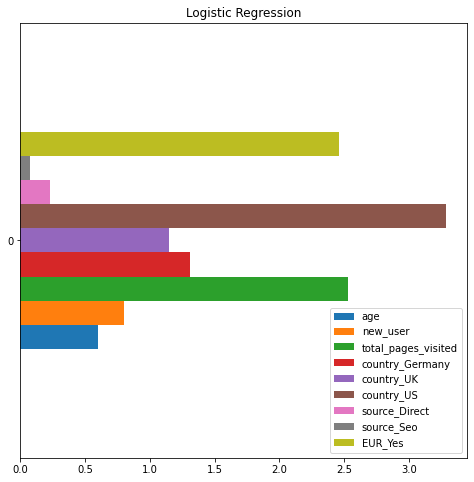

In [47]:
imp_feat.abs().plot(kind='barh', figsize=(8, 8))
plt.title('Logistic Regression')
plt.show()

Country is very significant for this model, outshining total_pages_visited.

### Decision Tree

In [50]:
dtc_clf = DecisionTreeClassifier()
params = {
    'max_depth': [4,8,12,16],
    'min_samples_split': [2,4,8,12,16],
    'min_samples_leaf' : [1,4,6,8,10]
}

gridsearch = GridSearchCV(dtc_clf, param_grid = params, n_jobs=-1, cv = 5,scoring='f1') 
gridsearch.fit(X_train, Y_train)
print("Best: %f using %s" % (gridsearch.best_score_, gridsearch.best_params_))

Best: 0.756090 using {'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 16}


In [51]:
dtc_clf = DecisionTreeClassifier(max_depth= 8,min_samples_leaf= 6, min_samples_split= 16)
dtc_clf.fit(X_train,Y_train)

train_pred = dtc_clf.predict(X_train)
test_pred = dtc_clf.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, train_pred))
print("f1-score on test set : ", f1_score(Y_test, test_pred))

f1-score on train set :  0.7660183928840645
f1-score on test set :  0.7617317590069634


### Random Forest

In [59]:
model = RandomForestClassifier()
params = {
    'max_depth': [6,8,10,12],
    'min_samples_split': [12,16,20,24],
    'n_estimators': [80,100,120,140]
}

gridsearch = GridSearchCV(model, param_grid = params, n_jobs=-1, cv = 5,scoring='f1') 
gridsearch.fit(X_train, Y_train)
print("Best: %f using %s" % (gridsearch.best_score_, gridsearch.best_params_))

Best: 0.760463 using {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 100}


In [49]:
forest_clf = RandomForestClassifier(random_state=42,max_depth= 10, min_samples_split= 20, n_estimators= 100)
forest_clf.fit(X_train, Y_train)

train_pred = forest_clf.predict(X_train)
test_pred = forest_clf.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, train_pred))
print("f1-score on test set : ", f1_score(Y_test, test_pred))

f1-score on train set :  0.7762940735183796
f1-score on test set :  0.7604953186348534


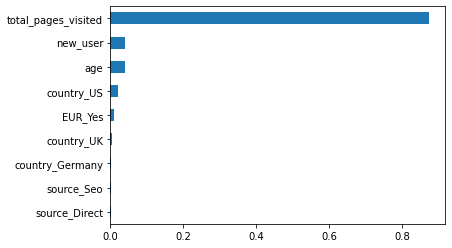

In [54]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())
feat_importances = pd.Series(forest_clf.feature_importances_, index=col_names)
feat_importances.sort_values().plot(kind='barh')
plt.show()

Random forest is overwhelmingly reliant on total_pages_visited (same for decision tree, naturally). Performance is not particularly promising for improvement upon simple Logistic Regression.
Better results could certainly be achieved with more tuning of hyperparameters, but maybe time would be better spent on other models.

### Ada Boost

In [15]:
model = AdaBoostClassifier(log_reg_clf)
params = { 
    'n_estimators': [60,80,100,120] 
}

gridsearch = GridSearchCV(model, param_grid = params, n_jobs=-1, cv = 5,scoring='f1')
gridsearch.fit(X_train, Y_train)
print("Best: %f using %s" % (gridsearch.best_score_, gridsearch.best_params_))

Best: 0.760045 using {'n_estimators': 100}


In [57]:
ada_clf = AdaBoostClassifier(log_reg_clf, n_estimators=100)
ada_clf.fit(X_train,Y_train)
train_pred = ada_clf.predict(X_train)
test_pred = ada_clf.predict(X_test)
print("f1-score on train set : ", f1_score(Y_train, train_pred))
print("f1-score on test set : ", f1_score(Y_test, test_pred))

f1-score on train set :  0.7608003638017281
f1-score on test set :  0.7639902676399026


### XG Boost

In [24]:
model = XGBClassifier()

params = {
        'min_child_weight': [4,8,12],
        'n_estimators': [20, 30, 40],
        'gamma': [0.5, 1, 1.5],
        'max_depth': [4,8,12],
        'subsample': [0.6,0.8,1.0],
        'colsample_bytree': [0.6,0.8,1.0]
        }

gridsearch = GridSearchCV(model, param_grid = params, n_jobs=-1, cv = 5,scoring='f1')
gridsearch.fit(X_train, Y_train)
print("Best: %f using %s" % (gridsearch.best_score_, gridsearch.best_params_))

Best: 0.763637 using {'colsample_bytree': 0.6, 'gamma': 1, 'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 30, 'subsample': 0.8}


In [58]:
xgb_clf = XGBClassifier(max_depth= 8, n_estimators = 60, min_child_weight= 12,colsample_bytree=0.4,gamma=1,subsample=0.6)
xgb_clf.fit(X_train,Y_train)
train_pred = xgb_clf.predict(X_train)
test_pred = xgb_clf.predict(X_test)
print("f1-score on train set : ", f1_score(Y_train, train_pred))
print("f1-score on test set : ", f1_score(Y_test, test_pred))

f1-score on train set :  0.7643829435210949
f1-score on test set :  0.7664453832226916


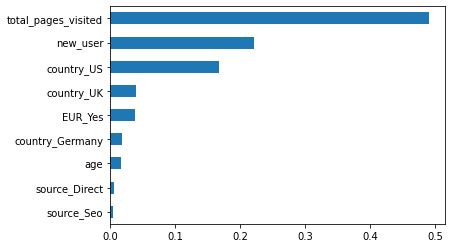

In [59]:
feat_importances = pd.Series(xgb_clf.feature_importances_, index=col_names)
feat_importances.sort_values().plot(kind='barh')
plt.show()

XGBoost gives out good performance and is the most stable model yet.

### Voting

In [73]:
v_clf = VotingClassifier(estimators=[
         ('logreg', log_reg_clf), ('xgb', xgb_clf), ('forest',forest_clf)],voting='soft',weights=[2,3,1])
v_clf = v_clf.fit(X_train, Y_train)
train_pred = v_clf.predict(X_train)
test_pred = v_clf.predict(X_test)
print("f1-score on train set : ", f1_score(Y_train, train_pred))
print("f1-score on test set : ", f1_score(Y_test, test_pred))

f1-score on train set :  0.7672323171647394
f1-score on test set :  0.7670488835244418


## Evaluating model in more detail

Confusion matrix on train set : 


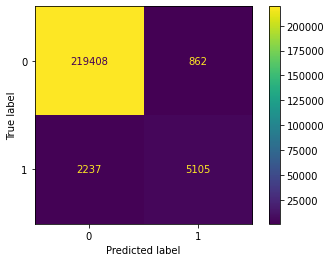

Confusion matrix on test set : 


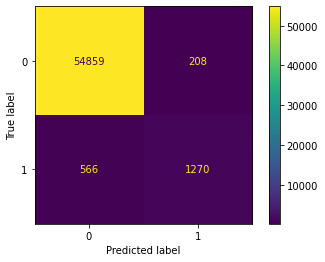

In [62]:
print("Confusion matrix on train set : ")
cm_train = confusion_matrix(Y_train, train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=v_clf.classes_)
disp_train.plot()
plt.show()
print("Confusion matrix on test set : ")
cm_test = confusion_matrix(Y_test, test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=v_clf.classes_)
disp_test.plot()
plt.show()

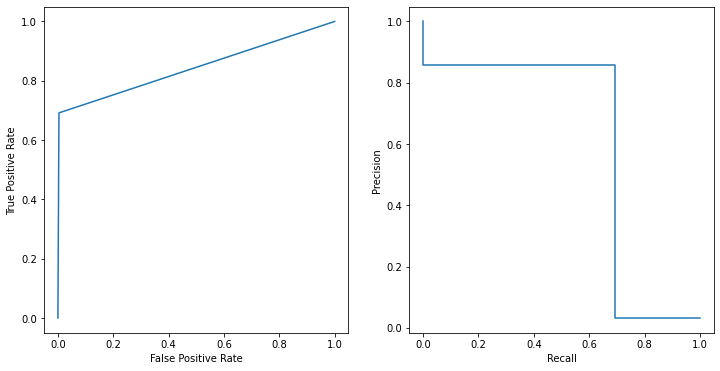

In [63]:
fpr, tpr, _ = roc_curve(Y_test, test_pred)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
prec, recall, _ = precision_recall_curve(Y_test, test_pred, pos_label=v_clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

In [65]:
models = [log_reg_clf,dtc_clf,forest_clf,ada_clf,xgb_clf,v_clf]
models_name = ['Logistic Regression', 'Decision Tree Classifier','Random Forest Classifier', 'Ada Boost Classifier', 'XGBoost Classifier', 'Voting Classifier']
for i in range(len(models)):
    scores = cross_val_score(models[i], X_test, Y_test, cv=5, scoring='f1')
    print(f"{models_name[i]} has a f1-score of {round(scores.mean(),4)} with standard deviation of {round(scores.std(),4)}")

Logistic Regression has a f1-score of 0.7674 with standard deviation of 0.0116
Decision Tree Classifier has a f1-score of 0.7407 with standard deviation of 0.0172
Random Forest Classifier has a f1-score of 0.7625 with standard deviation of 0.0167
Ada Boost Classifier has a f1-score of 0.7667 with standard deviation of 0.0127
XGBoost Classifier has a f1-score of 0.7665 with standard deviation of 0.0144
Voting Classifier has a f1-score of 0.7668 with standard deviation of 0.0132


All models gave decent and fairly close results on test data except for simple decision tree.

# Best classifier on all data and predictions on X_without_labels

In [71]:
# Concatenate train and test set to train the best classifiers on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

v_clf.fit(X,Y)
# Predictions on full set
pred = v_clf.predict(X)
print("f1-score on full set : ", f1_score(Y, pred))

f1-score on full set :  0.764958039002596


Performance shifted a bit between models with all data, but all still performed within similar ranges of f1-score.
The Voting Ensemble performed a little better than all other models, followed closely by XGBoost and Logistic Regression.

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('data/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Add the EUR column here as well
data_without_labels['EUR'] = data_without_labels['country'].map(lambda x: 'Yes' if x != 'US' and x!= 'China' else 'No')
X_without_labels = data_without_labels.loc[:, features_list]
print(data_without_labels.head())
# same preprocessing on X_without_labels
X_without_labels = preprocessor.transform(X_without_labels)

Prediction set (without labels) : (31620, 5)
  country  age  new_user  source  total_pages_visited   EU
0      UK   28         0     Seo                   16  Yes
1      UK   22         1  Direct                    5  Yes
2   China   32         1     Seo                    1   No
3      US   32         1     Ads                    6   No
4   China   25         0     Seo                    3   No


In [ ]:
print("X_without_labels represents",round((len(X_without_labels)/len(X)*100),2),"% of the data used to build the model.")

X_without_labels represents 11.11 % of the data used to build the model.


In [ ]:
# Make predictions and dump to file according to challenge requirements

data = {
    'converted': v_clf.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('result/conversion_data_test_predictions_ab-m9.csv', index=False)


## Model performance

Since the challenge allowed multiples entries, it was interesting to check how the different models performed against the test target.

Submissions to the challenge are incurring a small fall from previous testing, which could be attributed to the small size of the challenge test data.
All had a f1-score between 0.736 and 0.76, which wasn't a particularly surprising drop from the scores on train data given standard deviation : the models can decently generalize.

Ranking as follows, from worse to best :

- Decision Tree
- Random Forest
- AdaBoost Decision Tree
- Voting Classifier (Random Forest, XGBoost (default), Logistic Regression ; no weights)
- Logistic Regression
- AdaBoost Logistic Regression
- XGBoost (default)
- XGBoost (optimized hyperparameters)

XGBoost performed really well, even with default settings.
The weighted Voting Classifier with updated hyperparameters was untested against the challenge target because of time constraints, but would likely provide interesting results given that it was the best on our train/test data.

## Conclusions

- On data <br>

The site is working best for young users ; we observe a steady drop in conversion rate correlated with age.
Germany has the highest conversion rate. An opportunity to explore more than US audience ?
The abysmal rate for China could indicate something wrong with the site, but we only have a very small sample compared to actual population.

Older accounts do much better, finding a way to hold on to them could provide better results than targetting new ones.

- Regarding modeling <br>

Some combinations of models and hyperparameters were ignored because of the time required to implement them but could yield better results, such as a wider range of parameters or introducing bagging and stacking.<br>
Focusing on improving recall (though without sacrificing accuracy) seems to be a good way forward to fine-tune the model and evaluate improvement.


Oversampling techniques might also provide interesting insights to study possible effects of a strategy targeting a region and/or age range.
